# Proyek Analisis Sentimen Aplikasi Bareksa

Nama        : Salsa Zufar Radinka Akmal

Email       : salsazufar@gmail.com

ID Dicoding : salsazufar

## Importing Libraries

In [76]:
import pandas as pd

# Non aktifkan peringatan chained
pd.options.mode.chained_assignment = None

import numpy as np
seed = 0
np.random.seed(seed)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import datetime as dt
import re
import string
from nltk.tokenize import word_tokenize # type: ignore
from nltk.corpus import stopwords # type: ignore
from nltk.sentiment import SentimentIntensityAnalyzer

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Loading

In [77]:
app_reviews_df = pd.read_csv('ulasan_aplikasi.csv')

In [78]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,afa3e64b-7e83-4b25-95e4-4936286185be,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Terimakasih atas bantuannya sehingga kendala y...,5,2,4.19.0,2025-01-15 11:01:52,Hai Kak. Terima kasih telah memberikan saran d...,2025-01-16 13:25:11,4.19.0
1,567e77a1-cd1e-494c-9b4e-62982953b0b3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi sudah bagus, tapi masih ada yang kura...",5,2,4.19.0,2025-01-13 08:59:23,Terima kasih telah memberikan feedback terhada...,2025-01-13 10:23:40,4.19.0
2,4f05ef0f-bcd6-429f-9256-a23228e54045,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"awal mengenal Bareksa dari teman, anak anak mu...",5,1,4.19.0,2025-01-13 07:30:43,Terima kasih telah memberikan feedback terhada...,2025-01-13 10:23:03,4.19.0
3,0e1b7307-6b82-40be-9e25-bce831e3f7cb,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Cuma karena pergantian nama, saldo saya tidak ...",1,13,4.19.0,2025-01-09 12:20:08,Kami membutuhkan kelengkapan dokumen untuk pro...,2025-01-09 15:12:32,4.19.0
4,c6b00bf4-0ada-4d83-b716-643060d27e9a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi buruk, lama sekali penanganan nya, sa...",1,17,4.17.0,2024-11-18 15:36:42,Mohon maaf atas ketidaknyamanannya. Untuk pert...,2024-11-18 15:54:42,4.17.0


In [79]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              7905 non-null   object
 1   userName              7905 non-null   object
 2   userImage             7905 non-null   object
 3   content               7905 non-null   object
 4   score                 7905 non-null   int64 
 5   thumbsUpCount         7905 non-null   int64 
 6   reviewCreatedVersion  6611 non-null   object
 7   at                    7905 non-null   object
 8   replyContent          7734 non-null   object
 9   repliedAt             7734 non-null   object
 10  appVersion            6611 non-null   object
dtypes: int64(2), object(9)
memory usage: 679.5+ KB


In [80]:
# Data cleaning
clean_df = app_reviews_df.dropna()
clean_df = clean_df.drop_duplicates()
clean_df.shape

(6475, 11)

## Preprocessing Text

In [81]:
def cleaningText(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)
  text = re.sub(r'#[A-Za-z0-9]+', '', text)
  text = re.sub(r'RT[\s]+', '', text)
  text = re.sub(r'https?:\/\/\S+', '', text)
  text = re.sub(r'[0-9]+', '', text)
  text = re.sub(r'[^\w\s]', '', text)

  text = text.replace('\n', ' ')
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = text.strip(' ')
  return text

def casefoldingText(text):
  text = text.lower()
  return text

def tokenizingText(text):
  text = word_tokenize(text)
  return text

def filteringText(text):
  listStopwords = set(stopwords.words('indonesian'))
  listStopwords1 = set(stopwords.words('english'))
  listStopwords.update(listStopwords1)
  listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
  filtered = []
  for txt in text:
    if txt not in listStopwords:
      filtered.append(txt)
  text = filtered
  return text

def stemmingText(text):
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Split teks
    words = text.split()

    # stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata 
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): 
    sentence = ' '.join(word for word in list_words)
    return sentence

In [82]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal"}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
      if word.lower() in slangwords:
        fixed_words.append(slangwords[word.lower()])
      else:
        fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text


In [83]:
# Membersihkan teks
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata)
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum)
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [84]:
clean_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,afa3e64b-7e83-4b25-95e4-4936286185be,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Terimakasih atas bantuannya sehingga kendala y...,5,2,4.19.0,2025-01-15 11:01:52,Hai Kak. Terima kasih telah memberikan saran d...,2025-01-16 13:25:11,4.19.0,Terimakasih atas bantuannya sehingga kendala y...,terimakasih atas bantuannya sehingga kendala y...,terimakasih atas bantuannya sehingga kendala y...,"[terimakasih, atas, bantuannya, sehingga, kend...","[terimakasih, bantuannya, kendala, alami, tera...",terimakasih bantuannya kendala alami teratasi ...
1,567e77a1-cd1e-494c-9b4e-62982953b0b3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi sudah bagus, tapi masih ada yang kura...",5,2,4.19.0,2025-01-13 08:59:23,Terima kasih telah memberikan feedback terhada...,2025-01-13 10:23:40,4.19.0,Aplikasi sudah bagus tapi masih ada yang kuran...,aplikasi sudah bagus tapi masih ada yang kuran...,aplikasi sudah bagus tapi masih ada yang kuran...,"[aplikasi, sudah, bagus, tapi, masih, ada, yan...","[aplikasi, bagus, fitur, nabung, rutin, fitur,...",aplikasi bagus fitur nabung rutin fitur penamb...
2,4f05ef0f-bcd6-429f-9256-a23228e54045,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"awal mengenal Bareksa dari teman, anak anak mu...",5,1,4.19.0,2025-01-13 07:30:43,Terima kasih telah memberikan feedback terhada...,2025-01-13 10:23:03,4.19.0,awal mengenal Bareksa dari teman anak anak mud...,awal mengenal bareksa dari teman anak anak mud...,awal mengenal bareksa dari teman anak anak mud...,"[awal, mengenal, bareksa, dari, teman, anak, a...","[mengenal, bareksa, teman, anak, anak, muda, y...",mengenal bareksa teman anak anak muda yg akses...
3,0e1b7307-6b82-40be-9e25-bce831e3f7cb,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Cuma karena pergantian nama, saldo saya tidak ...",1,13,4.19.0,2025-01-09 12:20:08,Kami membutuhkan kelengkapan dokumen untuk pro...,2025-01-09 15:12:32,4.19.0,Cuma karena pergantian nama saldo saya tidak b...,cuma karena pergantian nama saldo saya tidak b...,cuma karena pergantian nama saldo saya tidak b...,"[cuma, karena, pergantian, nama, saldo, saya, ...","[pergantian, nama, saldo, cair, verifikasi, me...",pergantian nama saldo cair verifikasi menyerta...
4,c6b00bf4-0ada-4d83-b716-643060d27e9a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi buruk, lama sekali penanganan nya, sa...",1,17,4.17.0,2024-11-18 15:36:42,Mohon maaf atas ketidaknyamanannya. Untuk pert...,2024-11-18 15:54:42,4.17.0,Aplikasi buruk lama sekali penanganan nya saya...,aplikasi buruk lama sekali penanganan nya saya...,aplikasi buruk lama sekali penanganan nya saya...,"[aplikasi, buruk, lama, sekali, penanganan, ny...","[aplikasi, buruk, penanganan, berkali, kali, m...",aplikasi buruk penanganan berkali kali membeli...


## Labeling

In [85]:
# Mendownload lexicon 'vader' 
nltk.download('vader_lexicon')

# Membuat objek SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

clean_df['polarity'] = clean_df['text_akhir'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Mengubah skor sentimen menjadi label sentimen
# Jika skor > 0, labelnya adalah 'positif'
# Jika skor < 0, labelnya adalah 'negatif'
# Jika skor = 0, labelnya adalah 'netral'
clean_df['polarity'] = clean_df['polarity'].apply(lambda x: 'positif' if x > 0 else ('negatif' if x < 0 else 'netral'))

# Menampilkan kolom 'content' (isi review asli) dan 'sentiment' (label sentimen) dari DataFrame reviews
clean_df[['content', 'polarity']]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,content,polarity
0,Terimakasih atas bantuannya sehingga kendala y...,netral
1,"Aplikasi sudah bagus, tapi masih ada yang kura...",netral
2,"awal mengenal Bareksa dari teman, anak anak mu...",netral
3,"Cuma karena pergantian nama, saldo saya tidak ...",netral
4,"Aplikasi buruk, lama sekali penanganan nya, sa...",netral
...,...,...
7856,Ok banget,positif
7864,Mantap bareksa,netral
7883,User friendly,positif
7884,Good job,positif


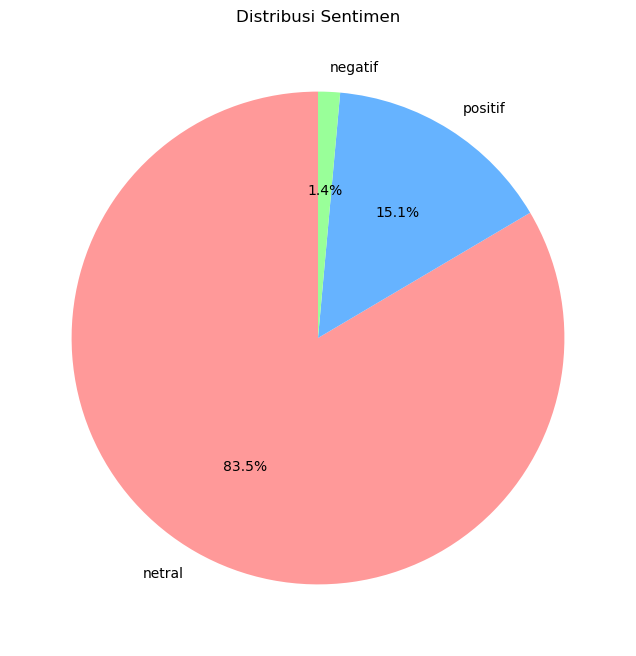

In [86]:
# Menghitung nilai dari kolom 'polarity'
polarity_counts = clean_df['polarity'].value_counts()

# Membuat pie chart
plt.figure(figsize=(8, 8))
polarity_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribusi Sentimen')
plt.ylabel('')  # Menghilangkan label y
plt.show()

## Split Data dengan test size 0.2

In [87]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = clean_df['text_akhir']
y = clean_df['polarity']

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=2000, min_df=15, max_df=0.9 )
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

## Modeling dengan test size 0.2

### Naive Bayes

In [88]:
# Membuat objek model Naive Bayes (Bernoulli Naive Bayes)
naive_bayes = BernoulliNB()

# Melatih model Naive Bayes pada data pelatihan
naive_bayes.fit(X_train.toarray(), y_train)

# Melakukan prediksi sentimen pada data pelatihan
y_pred_train_nb = naive_bayes.predict(X_train.toarray())

# Melakukan prediksi sentimen pada data uji
y_pred_test_nb = naive_bayes.predict(X_test.toarray())

# Menghitung akurasi model Naive Bayes pada data pelatihan
accuracy_train_nb = accuracy_score(y_pred_train_nb, y_train)

# Menghitung akurasi model Naive Bayes pada data uji
accuracy_test_nb = accuracy_score(y_pred_test_nb, y_test)

# Menampilkan akurasi model Naive Bayes
print('Naive Bayes - Akurasi pada data pelatihan:', accuracy_train_nb)
print('Naive Bayes - Akurasi pada data uji:', accuracy_test_nb)

Naive Bayes - Akurasi pada data pelatihan: 0.9247104247104247
Naive Bayes - Akurasi pada data uji: 0.9111969111969112


### Random Forest

In [89]:
# Membuat objek model Random Forest
random_forest = RandomForestClassifier()

# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train.toarray(), y_train)

# Melakukan prediksi sentimen pada data pelatihan
y_pred_train_rf = random_forest.predict(X_train.toarray())

# Melakukan prediksi sentimen pada data uji
y_pred_test_rf = random_forest.predict(X_test.toarray())

# Menghitung akurasi model Random Forest pada data pelatihan
accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)

# Menghitung akurasi model Random Forest pada data uji
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

# Menampilkan akurasi model Random Forest
print('Random Forest - Akurasi pada data pelatihan:', accuracy_train_rf)
print('Random Forest - Akurasi pada data uji:', accuracy_test_rf)

Random Forest - Akurasi pada data pelatihan: 0.9932432432432432
Random Forest - Akurasi pada data uji: 0.9660231660231661


### Logistic Regression

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train.toarray(), y_train)

# Melakukan prediksi sentimen pada data pelatihan
y_pred_train_lr = logistic_regression.predict(X_train.toarray())

# Melakukan prediksi sentimen pada data uji
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

# Menghitung akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Menghitung akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi model Logistic Regression
print('Logistic Regression - Akurasi pada data pelatihan:', accuracy_train_lr)
print('Logistic Regression - Akurasi pada data uji:', accuracy_test_lr)

Logistic Regression - Akurasi pada data pelatihan: 0.9511583011583011
Logistic Regression - Akurasi pada data uji: 0.949034749034749


### XGBoost

In [91]:
# Mengubah label string menjadi numerik
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Membuat objek model XGBoost
xgboost = XGBClassifier()

# Melatih model XGBoost pada data pelatihan
xgboost.fit(X_train.toarray(), y_train_encoded)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_xgb = xgboost.predict(X_train.toarray())
y_pred_test_xgb = xgboost.predict(X_test.toarray())

# Mengubah prediksi kembali ke label string
y_pred_train_xgb = label_encoder.inverse_transform(y_pred_train_xgb)
y_pred_test_xgb = label_encoder.inverse_transform(y_pred_test_xgb)

# Evaluasi akurasi model XGBoost
accuracy_train_xgb = accuracy_score(y_pred_train_xgb, y_train)
accuracy_test_xgb = accuracy_score(y_pred_test_xgb, y_test)

# Menampilkan akurasi
print('XGBoost - accuracy_train:', accuracy_train_xgb)
print('XGBoost - accuracy_test:', accuracy_test_xgb)

XGBoost - accuracy_train: 0.977992277992278
XGBoost - accuracy_test: 0.9667953667953668


### LSTM

#### Split Data khusus LSTM

In [92]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

#### Text Preprocessing

In [93]:
# Hyperparameters
MAX_WORDS = 10000
MAX_LEN = 100
EMBEDDING_DIM = 200
LSTM_UNITS = 128

# Tokenisasi 
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train_raw)

# Konversi teks ke sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

# Konversi label
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Konversi ke categorical
num_classes = len(label_encoder.classes_)
y_train_cat = tf.keras.utils.to_categorical(y_train_encoded, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test_encoded, num_classes)

#### Model Building

In [94]:
# Membangun Model LSTM
model = Sequential([
    # Layer Embedding 
    Embedding(MAX_WORDS, EMBEDDING_DIM),

    Dropout(0.3),

    Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(LSTM(LSTM_UNITS//2)),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])


In [95]:
# Compile Model
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Mengubah ekstensi file dari .h5 ke .keras
model_checkpoint = ModelCheckpoint(
    'best_lstm_model.keras',  
    monitor='val_accuracy',
    save_best_only=True
)

#### Train and Test Model

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - accuracy: 0.8189 - loss: 0.5742 - val_accuracy: 0.8234 - val_loss: 0.4233
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9073 - loss: 0.2746 - val_accuracy: 0.9498 - val_loss: 0.1901
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.9736 - loss: 0.0786 - val_accuracy: 0.9556 - val_loss: 0.1799
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9872 - loss: 0.0400 - val_accuracy: 0.9527 - val_loss: 0.1693
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - accuracy: 0.9963 - loss: 0.0163 - val_accuracy: 0.9604 - val_loss: 0.2082
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.9977 - loss: 0.0070 - val_accuracy: 0.9189 - val_loss: 0.3459
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - accuracy: 0.9978 - loss: 0.0046 - val_accuracy: 0.9585 - val_loss: 0.2574
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - accuracy: 0.9980 - loss: 0

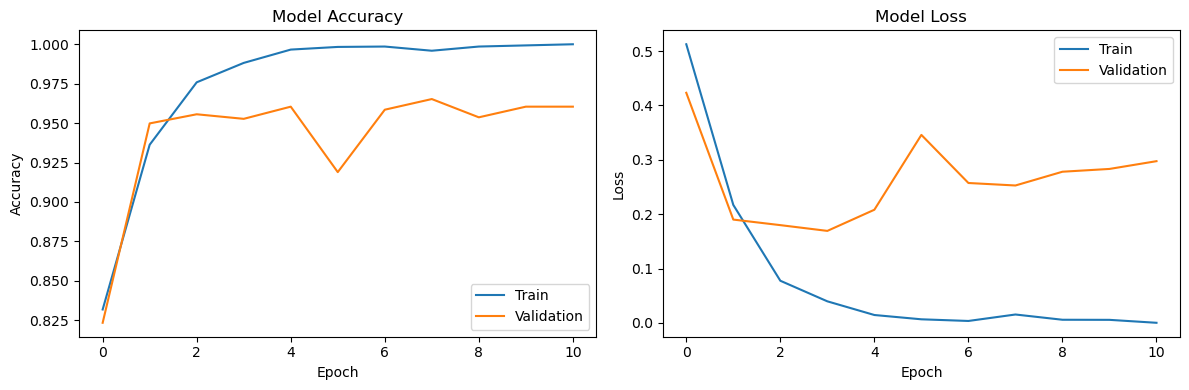

In [96]:
# Melatih Model
history = model.fit(
    X_train_pad,
    y_train_cat,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluasi Model
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_cat)
print(f"Test accuracy: {test_accuracy:.4f}")

# Prediksi
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)

# Visualisasi hasil training
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

### Inferensi dengan LSTM

In [98]:
# Fungsi untuk prediksi teks baru
def predict_sentiment(text):
    sequences = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequences, maxlen=MAX_LEN)
    prediction = model.predict(padded)
    predicted_class = np.argmax(prediction, axis=1)
    return label_encoder.inverse_transform(predicted_class)[0]

predict_sentiment('Aplikasi ini memiliki fitur yang lengkap untuk pemantauan saham. Antarmuka mudah dipahami, meskipun beberapa fungsi butuh waktu untuk dipelajari. Cocok untuk pengguna pemula maupun menengah.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


'netral'

## Kesimpulan

Setelah melakukan pelatihan dan evaluasi pada beberapa model machine learning untuk analisis sentimen, berikut adalah hasil akurasi dari masing-masing model:

- **Naive Bayes**
  - Akurasi pada data pelatihan: `0.92`
  - Akurasi pada data uji: `0.91`

- **Random Forest**
  - Akurasi pada data pelatihan: `0.99`
  - Akurasi pada data uji: `0.96`

- **Logistic Regression**
  - Akurasi pada data pelatihan: `0.95`
  - Akurasi pada data uji: `0.94`

- **XGBoost**
  - Akurasi pada data pelatihan: `0.97`
  - Akurasi pada data uji: `0.96`

- **LSTM**
  - Akurasi pada data pelatihan: `0.98`
  - Akurasi pada data uji: `0.96`

Dari hasil di atas, kita dapat melihat bahwa model dengan akurasi tertinggi pada data latih dan data uji adalah model LSTM. Oleh karena itu saat dilakukan proses inferensi dengan teks baru, model dapat mengklasifikasikan sentimen dengan baik.

Namun, penting juga untuk mempertimbangkan faktor lain seperti overfitting, waktu pelatihan, dan imbalance data pada class target. 